# MLP-ED MODEL


In [8]:
import numpy as np 
import pandas as pd 

import pydot

#import keras 
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model

import keras.backend as Kback

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

from math import exp

model_path = "model_MLP_Autoencoder.h5"

model_HI_test_path = "MLPmodel_MLP_HItest.h5"


In [2]:
## Data Ingestion ## from local

train_df = pd.read_csv("C:/Users/eduardo.tadeo/Documents/Master Thesis/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/Documents/Master Thesis/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/Documents/Master Thesis/Datasets/CMAPSSData/RUL_FD001.txt")

# Deleting unuseful columns
train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)
test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


In [ ]:
## Data Ingestion ## from ITH-Tower


train_df = pd.read_csv("/home/eoto/pm_nasa_cmapss/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("/home/eoto/pm_nasa_cmapss/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("/home/eoto/pm_nasa_cmapss/Datasets/CMAPSSData/RUL_FD001.txt")

# Deleting unuseful columns
train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)
test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


In [33]:
#Hyperparameters

health_length = 10

healthy_train = train_df[train_df['Cycle'] <= health_length]
healthy_test = test_df[test_df['Cycle'] <= health_length]


In [48]:
## Principal Component Analysis ##

#Columns to be scaled 

col_permanent = ['Unit', 'Cycle']
col_var = train_df.columns.difference(col_permanent)

# The PCA is introduced in order to reduce the dimensionality 

    # Training dataset

scaler = StandardScaler()
pca = PCA(0.95)
train_df_scaled = train_df[col_permanent].join(pd.DataFrame(pca.fit_transform(scaler.fit_transform(train_df[col_var])),
    index=train_df.index))

#scaler = StandardScaler()
test_df_scaled = test_df[col_permanent].join(pd.DataFrame(pca.transform(scaler.transform(test_df[col_var])),
    index=test_df.index))

col_train = train_df_scaled.columns.difference(col_permanent)

test_df_scaled.head()




,Unit,Cycle,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,-2.475403,-0.777619,1.482786,0.080010,-0.077868,-0.337896,-0.826615,0.921520,-0.393515,-0.616565,-0.461015,-0.490199
1,1,2,-3.566323,-0.040873,-1.520490,-0.408165,-0.459367,0.561212,1.260243,-0.117897,0.206018,-0.495765,0.167563,0.537475
2,1,3,-2.336877,-0.379826,0.385361,-0.196137,-0.169551,-0.050891,0.401225,0.680498,-0.077260,1.011673,-0.230607,-0.047288
3,1,4,-2.850192,-0.810491,1.328483,1.310859,-0.576017,-0.068813,-0.668261,0.035846,0.225531,-0.174019,0.672236,0.155964
4,1,5,-3.494312,-0.752334,0.477794,0.370824,-0.401362,0.567157,-1.189312,0.103837,-0.134968,0.041174,0.102103,-0.150675


In [49]:
train_df_scaled_healthy = train_df_scaled[train_df_scaled['Cycle']<=health_length][col_train].to_numpy()

train_df_scaled_healthy.shape


(1000, 12)

In [7]:
model = keras.models.load_model(model_path)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 400)               656000    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 5, 400)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 400)            1281600   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 9)              3609      
Total params: 1,941,209
Trainable params: 1,941,209
Non-trainable params: 0
_________________________________________________________________


In [50]:
### Autoencoder MLP ###

# Model parameters

input_dim = train_df_scaled_healthy.shape[1]
encoding_dim = 8
decoding_dim = 10

# Model definition

input_window = Input(shape=(input_dim,))
encoded = Dense(4, activation='relu')(input_window)
decoded = Dense(input_dim, activation = 'relu')(encoded)

model = Model(input_window, decoded)

encoder = Model(input_window,encoded)

model.compile(optimizer='adam', loss = 'mse', metrics = ['mae','mse'])

# Model fitting

model.summary()

model.fit(train_df_scaled_healthy, train_df_scaled_healthy, epochs = 300, verbose = 2, 
    callbacks = [keras.callbacks.ModelCheckpoint(model_path, monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)])



00155: loss improved from 1.01157 to 1.01152, saving model to model_MLP_Autoencoder.h5
Epoch 156/300
 - 0s - loss: 1.0114 - mae: 0.5841 - mse: 1.0114

Epoch 00156: loss improved from 1.01152 to 1.01143, saving model to model_MLP_Autoencoder.h5
Epoch 157/300
 - 0s - loss: 1.0114 - mae: 0.5840 - mse: 1.0114

Epoch 00157: loss improved from 1.01143 to 1.01141, saving model to model_MLP_Autoencoder.h5
Epoch 158/300
 - 0s - loss: 1.0114 - mae: 0.5839 - mse: 1.0114

Epoch 00158: loss improved from 1.01141 to 1.01139, saving model to model_MLP_Autoencoder.h5
Epoch 159/300
 - 0s - loss: 1.0114 - mae: 0.5837 - mse: 1.0114

Epoch 00159: loss improved from 1.01139 to 1.01139, saving model to model_MLP_Autoencoder.h5
Epoch 160/300
 - 0s - loss: 1.0113 - mae: 0.5837 - mse: 1.0113

Epoch 00160: loss improved from 1.01139 to 1.01130, saving model to model_MLP_Autoencoder.h5
Epoch 161/300
 - 0s - loss: 1.0113 - mae: 0.5835 - mse: 1.0113

Epoch 00161: loss improved from 1.01130 to 1.01128, saving model

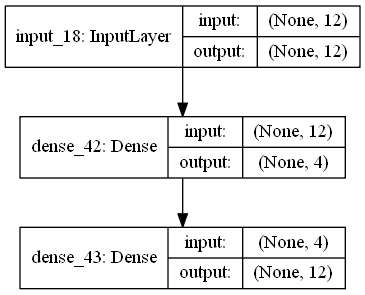

In [51]:
plot_model(model, show_shapes = True)

In [52]:
# Trained Autoencoder model accuracy

yhat = model.predict(train_df_scaled_healthy, verbose=0)
error = train_df_scaled_healthy - yhat

print("The autoencoder trained accuracy is: {}".format(np.mean(np.abs(error))))

print("Error shape: ", error.shape)

The autoencoder trained accuracy is: 0.5779552380005998
Error shape:  (1000, 12)


In [54]:
# Training set complete 

prediction_train_df = model.predict(train_df_scaled[col_train].to_numpy())

matrix_error = np.abs(prediction_train_df - train_df_scaled[col_train].to_numpy())

mean_error_train = np.mean(matrix_error, axis = 1)

print("Sequence shape: ", mean_error_train.shape)

train_df['error'] = mean_error_train



Sequence shape:  (20631,)


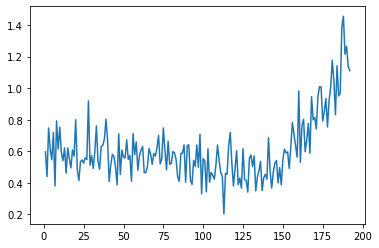

In [55]:
plt.plot(train_df[train_df['Unit']==1]['Cycle'], train_df[train_df['Unit']==1]['error'])

In [ ]:
train_df[train_df['Unit']==1].tail(20)

In [56]:
train_df['Health_Index'] = 0

#train_df.info()

for i in train_df['Unit'].unique():
    
    train_df.loc[train_df['Unit']==i, 'Health_Index'] = (train_df.loc[train_df['Unit']==i, 'error'].max() - train_df.loc[train_df['Unit']==i, 'error']) / (train_df.loc[train_df['Unit']==i, 'error'].max() - train_df.loc[train_df['Unit']==i, 'error'].min())

In [ ]:
train_df[train_df['Unit']==1].head(20)

In [ ]:
pd.DataFrame(mean_error_train).iloc[170:183,:]

In [57]:
def smooth(x,window_len=11,window='hanning'):

    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [58]:
vector_new = train_df[train_df['Unit']==1]['Health_Index']

num = round(len(vector_new)*0.05)

mean_HI_5 = np.mean(vector_new[:num])

vector_new = vector_new/mean_HI_5

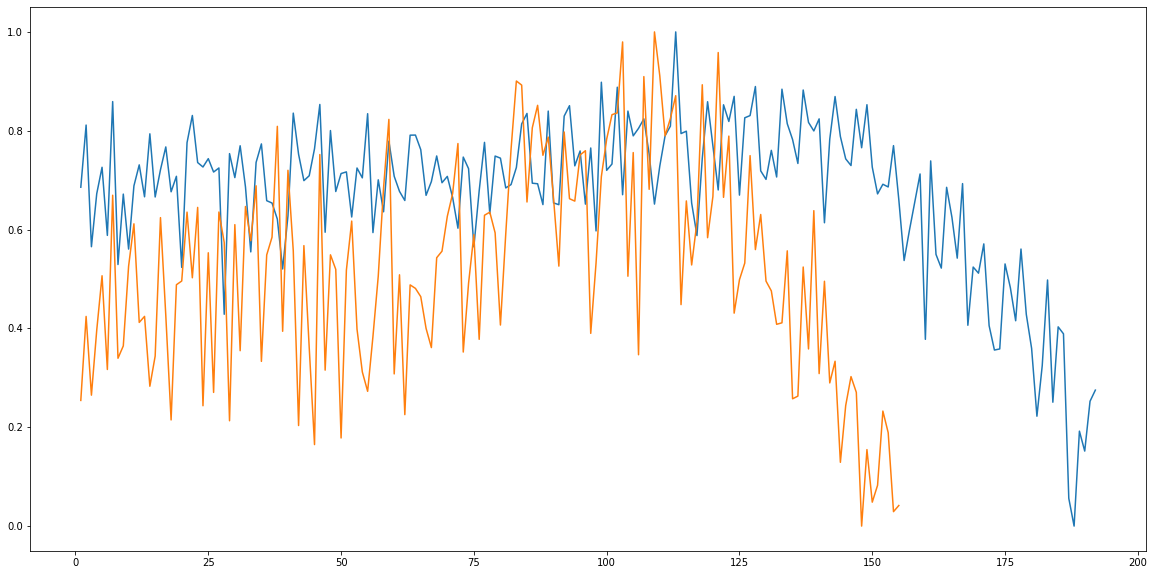

In [60]:
plt.figure(figsize = (20,10))
unit = 1


plt.plot(train_df.loc[train_df['Unit']==unit, 'Cycle'], train_df.loc[train_df['Unit']==unit, 'Health_Index'])

plt.plot(train_df.loc[train_df['Unit']==93, 'Cycle'], train_df.loc[train_df['Unit']==93, 'Health_Index'])

#plt.plot(train_df.loc[train_df['Unit']==1, 'Cycle'], vector_new)


In [61]:
def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

In [62]:
train_df.head()

,Unit,Cycle,OP1,OP2,OP3,T2,T24,T30,T50,P2,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,error,Health_Index
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0.597055,0.685745
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0.439506,0.811506
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0.747885,0.565348
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0.613523,0.672600
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0.546517,0.726086


In [66]:
# Train HI predictor
# Health Index can't be calculated by the same way as in the train set, as there is no minimum HI to calculate the failure.
# Therefore, a MLP is trained in order to predict the HI of every instance

# Model parameters

n_inputs = len(col_train)

# We are going to train the model on the Health Index from 90 turbines, and will be testing on the other ten 

train_HI = train_df_scaled[train_df_scaled['Unit']<=90][col_train]
label_train_HI = train_df[train_df['Unit']<= 90]['Health_Index']

test_HI = train_df_scaled[train_df_scaled['Unit'] >90][col_train]
label_test_HI = train_df[train_df['Unit'] > 90]['Health_Index']




model_HI = Sequential()

model_HI.add(Dense(n_inputs, input_dim = n_inputs, kernel_initializer = 'glorot_normal', activation = 'relu'))
model_HI.add(Dense(5, kernel_initializer = 'glorot_normal', activation = 'relu'))
model_HI.add(Dense(1, kernel_initializer = 'glorot_normal'))

model_HI.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mae', r2_keras])

print(model_HI.summary())

# Let's train the model

result = model_HI.fit(train_HI, label_train_HI, epochs = 100, batch_size = 100, validation_split = 0.05, verbose = 1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_HI_test_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)]
    )

print(result.history.keys())


    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 65        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 6         
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________
None
Train on 17461 samples, validate on 919 samples
Epoch 1/100
17461/17461 [==============================] - 1s 45us/step - loss: 0.1606 - mae: 0.3231 - r2_keras: -3.0478 - val_loss: 0.0567 - val_mae: 0.1907 - val_r2_keras: -2.0165
Epoch 2/100
17461/17461 [==============================] - 1s 32us/step - loss: 0.0414 - mae: 0.1625 - r2_keras: -0.0464 - val_loss: 0.0272 - val_mae: 

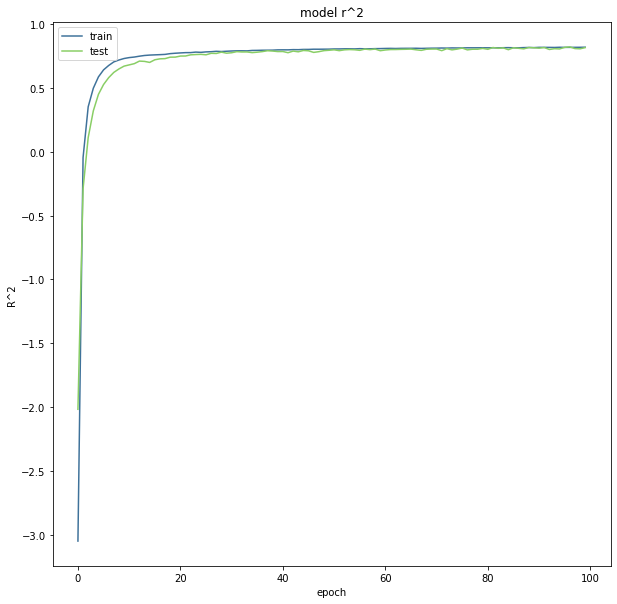

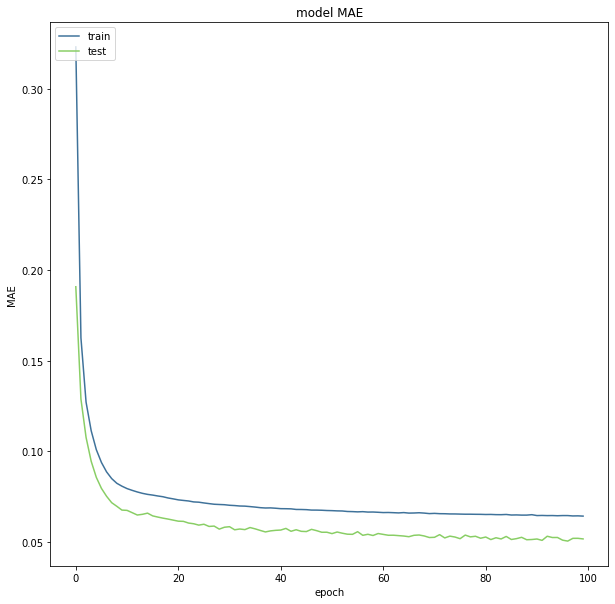

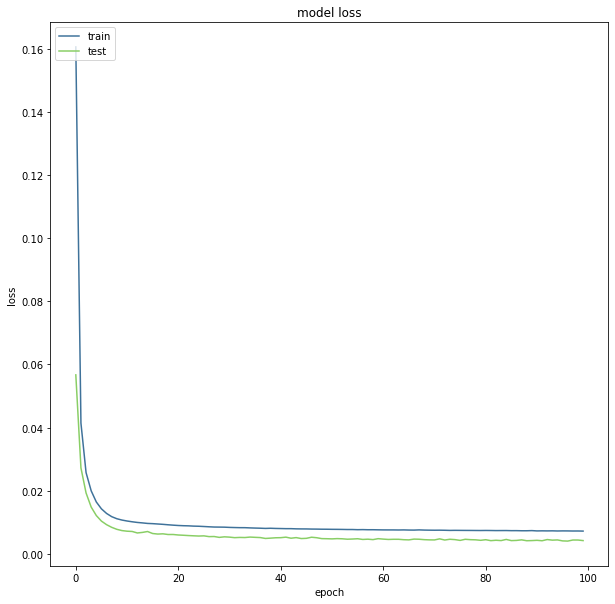

In [67]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")


In [68]:
# training metrics
scores = model_HI.evaluate(train_HI, label_train_HI, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model_HI.predict(test_HI,verbose=1, batch_size=200)
y_true = label_test_HI

#test_set = pd.DataFrame(y_pred)
#test_set.to_csv('submit_train.csv', index = None)

18380/18380 [==============================] - 0s 7us/step

MAE: 0.06340351700782776

R^2: 0.7904911041259766
2251/2251 [==============================] - 0s 28us/step



MAE: 0.07065971195697784

R^2: 0.24144099652767181


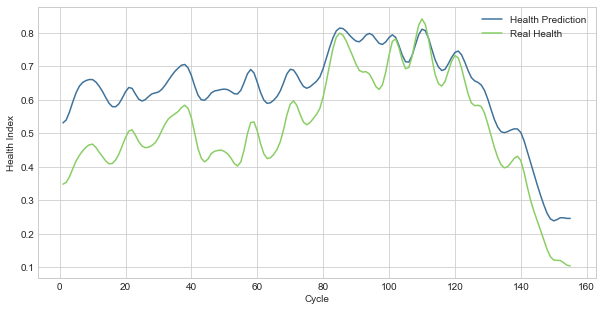

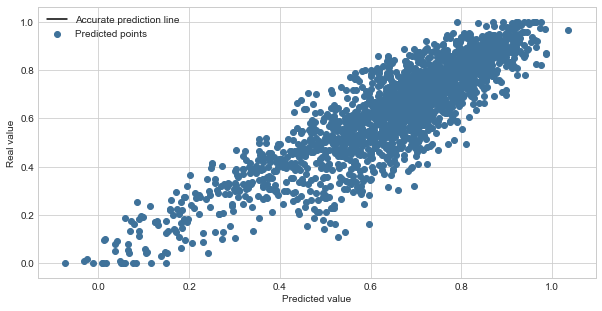

In [69]:
if os.path.isfile(model_HI_test_path):
    
    estimator = load_model(model_HI_test_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(test_HI, label_test_HI, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(test_HI)
    train_df['Health_Index_Predicted'] = 0
    train_df.loc[train_df['Unit']>90, 'Health_Index_Predicted'] = y_pred_test
    y_true_test = label_test_HI

    #test_set = pd.DataFrame(y_pred_test)
    #test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(train_df[train_df['Unit']==93]['Cycle'], smooth(train_df[train_df['Unit']==93]['Health_Index_Predicted'],window_len = 11)[5:-5], color="#3f729a")
    plt.plot( train_df[train_df['Unit']==93]['Cycle'],smooth(train_df[train_df['Unit']==93]['Health_Index'], window_len = 11 )[5:-5], color="#89ce65")
    plt.ylabel('Health Index')
    plt.xlabel('Cycle')
    plt.legend(['Health Prediction', 'Real Health'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()

In [61]:
test_df[test_df['Cycle']==test_df['Cycle'].max()]

,Unit,Cycle,OP1,OP2,OP3,T2,T24,T30,T50,P2,...,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,Sequence,error,UL,Num_Pred,Health_Index
6264,49,303,-0.0055,0.0001,100.0,518.67,643.21,1607.55,1425.3,14.62,...,396,2388,100.0,38.56,23.1167,0,0.158163,303.0,1.0,0.437564


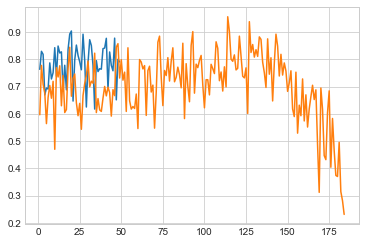

In [75]:

# Create HI curves for test dataset

test_df['Health_Index'] = model_HI.predict(test_df_scaled[col_train])

plt.plot(test_df.loc[test_df['Unit']==2, 'Cycle'], test_df.loc[test_df['Unit']==2, 'Health_Index'])

plt.plot(test_df.loc[test_df['Unit']==20, 'Cycle'], test_df.loc[test_df['Unit']==20, 'Health_Index'])





In [76]:
train_df['Health_Index_Smooth'] = smooth(train_df['Health_Index'], window_len = 11)[5:-5]
test_df['Health_Index_Smooth'] = smooth(test_df['Health_Index'], window_len = 11)[5:-5]

In [77]:
test_df[test_df['Health_Index']<0.5]

,Unit,Cycle,OP1,OP2,OP3,T2,T24,T30,T50,P2,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,Health_Index,Health_Index_Smooth
12,1,13,-0.0056,0.0003,100.0,518.67,641.94,1589.09,1403.94,14.62,...,8131.12,8.4166,0.03,392,2388,100.0,39.08,23.3677,0.471671,0.601021
176,3,97,-0.0073,-0.0003,100.0,518.67,642.86,1588.90,1408.72,14.62,...,8128.39,8.4480,0.03,392,2388,100.0,38.82,23.2457,0.490322,0.714286
202,3,123,-0.0057,0.0002,100.0,518.67,642.54,1596.49,1409.72,14.62,...,8125.94,8.4677,0.03,394,2388,100.0,38.65,23.2330,0.469201,0.623507
517,7,3,-0.0021,-0.0003,100.0,518.67,642.04,1577.27,1395.02,14.62,...,8137.55,8.3914,0.03,393,2388,100.0,38.99,23.3413,0.462816,0.598794
521,7,7,0.0002,0.0002,100.0,518.67,642.24,1578.19,1392.90,14.62,...,8136.81,8.3876,0.03,390,2388,100.0,39.28,23.3838,0.420174,0.586955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12922,100,25,-0.0029,-0.0003,100.0,518.67,642.03,1585.45,1398.81,14.62,...,8134.11,8.4169,0.03,392,2388,100.0,38.98,23.5615,0.449021,0.572899
12944,100,47,-0.0019,-0.0003,100.0,518.67,642.08,1587.53,1398.75,14.62,...,8137.19,8.3913,0.03,390,2388,100.0,38.98,23.3397,0.448810,0.624632
12962,100,65,-0.0039,0.0005,100.0,518.67,642.27,1589.34,1404.08,14.62,...,8138.76,8.4328,0.03,390,2388,100.0,39.00,23.3497,0.472186,0.598664
12967,100,70,-0.0044,0.0004,100.0,518.67,642.04,1579.83,1406.06,14.62,...,8140.52,8.4552,0.03,392,2388,100.0,39.10,23.3277,0.440235,0.613272


In [78]:
def similarity(test_unit, train_unit, time_lag, lambda_val):

    test_unit = test_unit.to_numpy()
    train_unit = train_unit.to_numpy()

    len_test = len(test_unit)
    len_train = len(train_unit[time_lag:(len_test+time_lag)])

    #print(len_test, len_train)
    #print(time_lag)
    
    distance = (1/len_test) * ((test_unit - train_unit[time_lag:(len_test+time_lag)])**2).sum()

    #print("Distance: ", distance)
    
    return exp(-distance/lambda_val)


max_timelag = 40


similarity_matrix = np.zeros((len(test_df['Unit'].unique()), len(train_df['Unit'].unique()),max_timelag+1))

max_sim = 0
best_time_lag = 0

for test_index in test_df['Unit'].unique():

    for train_index in train_df['Unit'].unique():

        print("Test: ", test_index)
        print("Train: ", train_index)

        for time_lag in range(max_timelag+1):

            test_unit = test_df[test_df['Unit']==test_index]['Health_Index']
            train_unit = train_df[train_df['Unit']==train_index]['Health_Index']

            if(len(test_unit) + time_lag <= len(train_unit)):
                
                similarity_matrix[test_index-1, train_index-1, time_lag] = similarity(test_unit,train_unit,time_lag, lambda_val = 0.0005)
            else:

                similarity_matrix[test_index-1, train_index-1, time_lag] = -1

        
#print(max_sim,best_time_lag)

#plt.plot(test_df.loc[test_df['Unit']==20, 'Cycle'] + best_time_lag, test_df.loc[test_df['Unit']==20, 'Health_Index'])

#plt.plot(train_df.loc[train_df['Unit']==96, 'Cycle'], train_df.loc[train_df['Unit']==96, 'Health_Index'])


Train:  44
Test:  91
Train:  45
Test:  91
Train:  46
Test:  91
Train:  47
Test:  91
Train:  48
Test:  91
Train:  49
Test:  91
Train:  50
Test:  91
Train:  51
Test:  91
Train:  52
Test: 91
Train:  53
Test:  91
Train:  54
Test:  91
Train:  55
Test:  91
Train:  56
Test:  91
Train:  57
Test: 91
Train:  58
Test: 91
Train:  59
Test:  91
Train:  60
Test:  91
Train:  61
Test:  91
Train:  62
Test: 91
Train:  63
Test:  91
Train:  64
Test:  91
Train:  65
Test:  91
Train:  66
Test:  91
Train:  67
Test: 91
Train:  68
Test:  91
Train:  69
Test:  91
Train:  70
Test:  91
Train:  71
Test:  91
Train:  72
Test:  91
Train:  73
Test:  91
Train:  74
Test:  91
Train:  75
Test:  91
Train:  76
Test:  91
Train:  77
Test:  91
Train:  78
Test:  91
Train:  79
Test:  91
Train:  80
Test:  91
Train:  81
Test: 91
Train:  82
Test:  91
Train:  83
Test: 91
Train:  84
Test:  91
Train:  85
Test:  91
Train:  86
Test:  91
Train:  87
Test:  91
Train:  88
Test:  91
Train:  89
Test:  91
Train:  90
Test:  91
Train:  91
Test:  91

In [82]:
for i in train_df['Unit'].unique():

    train_df.loc[train_df['Unit']==i, 'UL'] = train_df.loc[train_df['Unit']==i, 'Cycle'].max()

#RUL Prediction

max_RUL_prediction = train_df['UL'].max()

RUL_prediction_matrix = np.zeros(similarity_matrix.shape)

for test_index in test_df['Unit'].unique():

    for train_index in train_df['Unit'].unique():

        test_unit = test_df[test_df['Unit']==test_index]['Health_Index']
        train_unit = train_df[train_df['Unit']==train_index]['Health_Index']

        print("Test: ", test_index)
        print("Train: ", train_index)

        for time_lag in range(max_timelag+1):

            if len(test_unit) - time_lag < max_RUL_prediction:

                RUL_prediction_matrix[test_index-1, train_index-1, time_lag] = len(train_unit) - len(test_unit) - time_lag
            
            else:

                RUL_prediction_matrix[test_index-1, train_index-1, time_lag] = max_RUL_prediction






  91
Train:  49
Test:  91
Train:  50
Test:  91
Train:  51
Test:  91
Train:  52
Test:  91
Train:  53
Test:  91
Train:  54
Test: 91
Train:  55
Test:  91
Train:  56
Test:  91
Train:  57
Test:  91
Train:  58
Test:  91
Train:  59
Test:  91
Train:  60
Test:  91
Train:  61
Test:  91
Train:  62
Test:  91
Train:  63
Test:  91
Train:  64
Test:  91
Train:  65
Test:  91
Train:  66
Test:  91
Train:  67
Test:  91
Train:  68
Test:  91
Train:  69
Test:  91
Train:  70
Test:  91
Train:  71
Test:  91
Train:  72
Test:  91
Train:  73
Test:  91
Train:  74
Test:  91
Train:  75
Test:  91
Train:  76
Test:  91
Train:  77
Test:  91
Train:  78
Test:  91
Train:  79
Test:  91
Train:  80
Test:  91
Train:  81
Test:  91
Train:  82
Test:  91
Train:  83
Test:  91
Train:  84
Test:  91
Train:  85
Test:  91
Train:  86
Test:  91
Train:  87
Test:  91
Train:  88
Test:  91
Train:  89
Test:  91
Train:  90
Test:  91
Train:  91
Test:  91
Train:  92
Test:  91
Train:  93
Test:  91
Train:  94
Test:  91
Train:  95
Test:  91
Train:  9

In [83]:
RUL_final_prediction = np.zeros(len(train_df['Unit'].unique()))

alpha = 0.87

for test_index in test_df['Unit'].unique():

    #if test_index == 2:
     #   break
    
    weighted_sum = 0
    similarity_sum = 0

    for train_index in train_df['Unit'].unique():
        
        print("Test: ", test_index)
        print("Train: ", train_index)

        for time_lag in range(max_timelag+1):
            
            if similarity_matrix[test_index -1, train_index -1, time_lag] > similarity_matrix[test_index-1, :, :].max() * alpha:

                print("He entrado: ", similarity_matrix[test_index -1, train_index -1, time_lag])
                print("El limite es: ", similarity_matrix[test_index-1,:, :].max() * alpha)

                weighted_sum += similarity_matrix[test_index -1, train_index -1, time_lag] * RUL_prediction_matrix[test_index -1, train_index -1, time_lag]
                similarity_sum += similarity_matrix[test_index -1, train_index -1, time_lag]

    RUL_final_prediction[test_index-1] = round(weighted_sum/similarity_sum)

    print("Weighted sum: ", weighted_sum)
    print("RUL prediction: ", RUL_final_prediction[test_index-1])

 


:  92
Train:  20
Test:  92
Train:  21
Test:  92
Train:  22
Test:  92
Train:  23
Test:  92
Train:  24
Test:  92
Train:  25
Test:  92
Train:  26
Test:  92
Train:  27
Test:  92
Train:  28
Test:  92
Train:  29
Test:  92
Train:  30
Test:  92
Train:  31
Test:  92
Train:  32
Test:  92
Train:  33
Test:  92
Train:  34
Test:  92
Train:  35
Test:  92
Train:  36
Test:  92
Train:  37
Test:  92
Train:  38
Test:  92
Train:  39
Test:  92
Train:  40
Test:  92
Train:  41
Test:  92
Train:  42
Test:  92
Train:43
Test:  92
Train:  44
Test:  92
Train:  45
Test:  92
Train:  46
Test:  92
Train:  47
Test:  92
Train:  48
Test:  92
Train:  49
Test:  92
Train:  50
Test:  92
Train:  51
Test:  92
Train:  52
Test:  92
Train:  53
Test:  92
Train:  54
Test:  92
Train:  55
Test:  92
Train:  56
Test:  92
Train:  57
Test:  92
Train:  58
Test:  92
Train:  59
Test:  92
Train:  60
Test:  92
Train:  61
Test:92
Train:  62
Test:  92
Train:  63
Test:  92
Train:  64
Test:  92
Train:  65
Test:  92
Train:  66
Test:  92
Train:  67


The model score is: 243938.7737975139
The model accuracy is: 33.0
The model MAE is: 32.44
The model MSE is : 2081.96
The model Mean Absolute Percentage Error (MAPE) is: 67.95613288420354
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 16.145766912777756


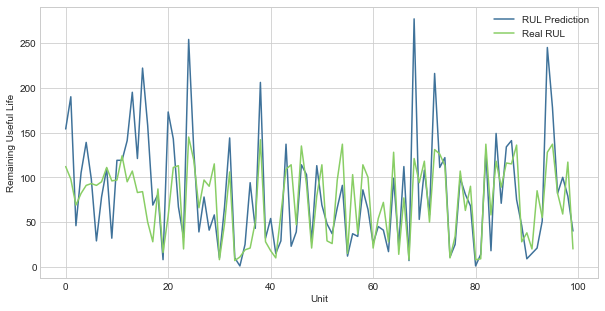

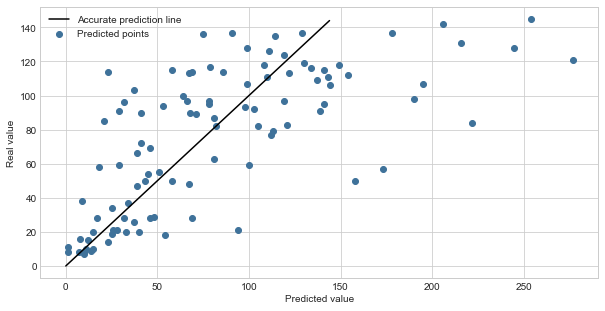

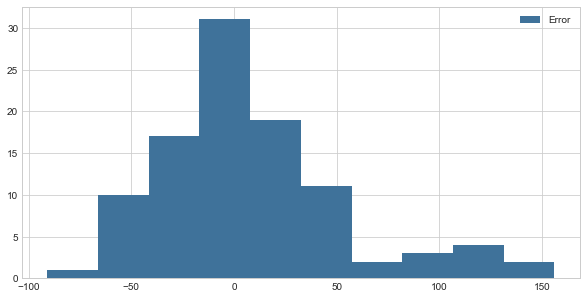

In [84]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(RUL_final_prediction, RUL_test.to_numpy()[:,0], test_df.groupby('Unit').max()['Cycle'].to_numpy())

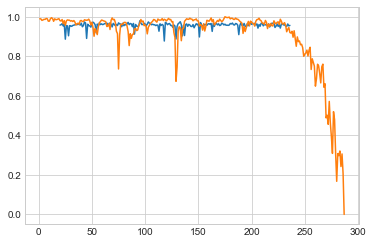

In [151]:
plt.plot(test_df.loc[test_df['Unit']==12, 'Cycle'] + 19, test_df.loc[test_df['Unit']==12, 'Health_Index'])

plt.plot(train_df.loc[train_df['Unit']==2, 'Cycle'], train_df.loc[train_df['Unit']==2, 'Health_Index'])
